In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [30]:
# Define a transform to preprocess the CelebA images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [31]:
# Load the CelebA dataset
# Note: You need to download the CelebA dataset and adjust the path accordingly.
# For example, if the dataset is in a folder named 'celeba', use:
# dataset_path = './celeba'
dataset_path = '/content/drive/MyDrive/data/celeba'  # Update this path to your CelebA dataset location

# Assuming all images are directly under 'celeba' and belong to a single class
# Create a dummy subfolder 'images' to satisfy ImageFolder's expectation
image_folder_path = os.path.join(dataset_path, 'images') # Create a path for a new folder called "images"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(image_folder_path):
    os.makedirs(image_folder_path)

# Move all files from the dataset_path to the new folder
for filename in os.listdir(dataset_path):
    if os.path.isfile(os.path.join(dataset_path, filename)):
        os.rename(os.path.join(dataset_path, filename), os.path.join(image_folder_path, filename))

train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform) # Root should now contain 'images' subfolder
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


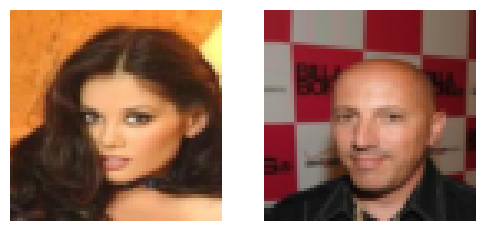

In [32]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to display images from the dataset
def display_images(dataset, num_images=2):
    # Get a batch of images from the dataset
    images, _ = next(iter(train_loader))  # Get the first batch of images
    images = images[:num_images]  # Select the first `num_images` images

    # Convert images from tensor to numpy and denormalize
    images = (images + 1) / 2  # Rescale from [-1, 1] to [0, 1]
    images = images.permute(0, 2, 3, 1)  # Change from (B, C, H, W) to (B, H, W, C) for matplotlib

    # Plot the images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i in range(num_images):
        axs[i].imshow(images[i])
        axs[i].axis('off')
    plt.show()

# Display two images from the CelebA dataset
display_images(train_dataset, num_images=2)

In [36]:
# Convolutional VAE Architecture for 64x64 images
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: 32x32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: 64x16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: 128x8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: 256x4x4
            nn.ReLU(),
            nn.Flatten()  # Output: 256 * 4 * 4 = 4096
        )

        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 4096)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: 128x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: 64x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: 32x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Output: 3x64x64
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 256, 4, 4)  # Reshape to match the input of the first transposed conv layer
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [37]:

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')  # Use MSE loss for better results
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [38]:

# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')


In [39]:

# Initialize the Convolutional VAE
latent_dim = 128
conv_vae = ConvVAE(latent_dim=latent_dim)
optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)

# Train the Convolutional VAE
for epoch in range(1, 11):  # Train for 10 epochs
    train(conv_vae, train_loader, optimizer, epoch)

Epoch 1, Loss: 4250.55234375
Epoch 2, Loss: 4184.13796875
Epoch 3, Loss: 4120.5634375
Epoch 4, Loss: 4054.73859375
Epoch 5, Loss: 4003.05078125
Epoch 6, Loss: 3878.00171875
Epoch 7, Loss: 3663.29015625
Epoch 8, Loss: 3572.86171875
Epoch 9, Loss: 3432.9384375
Epoch 10, Loss: 3354.906171875


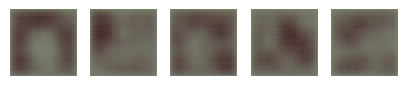

In [40]:
# Function to generate and display images from the latent space
def generate_images(model, num_images=10, latent_dim=128):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        # Reshape to (3, 64, 64) and then permute to (64, 64, 3) for imshow
        # Normalize images back to [0, 1] for display
        img = (generated_images[i].permute(1, 2, 0) + 1) / 2
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

# Generate and display images from the trained Convolutional VAE
generate_images(conv_vae, num_images=5, latent_dim=latent_dim)

In [41]:
# Function to sample from specific regions of the latent space
def sample_from_latent_space(model, latent_dim=128, num_samples=5, z_range=(-2, 2)):
    model.eval()
    with torch.no_grad():
        # Create a grid of latent vectors
        z = torch.linspace(z_range[0], z_range[1], num_samples).repeat(num_samples, 1)
        # Reshape to have latent_dim as the last dimension
        z = z.reshape(num_samples, num_samples, 1).repeat(1, 1, latent_dim)
        z = z.reshape(-1, latent_dim) # Now reshape to (-1, latent_dim)

        # Decode the latent vectors
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(num_samples, num_samples, figsize=(num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            img = (generated_images[i * num_samples + j].permute(1, 2, 0) + 1) / 2
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    plt.show()